In [ ]:
import os
os.chdir("..")
from IPython.display import display
import pandas
import matplotlib.pyplot

In [9]:
import pathlib
import pandas
import numpy
import functools
import collections
import hashlib
import charmonium.time_block
from typing import Mapping, Callable
from util import flatten1
from prov_collectors import PROV_COLLECTORS
from workloads import WORKLOADS


rel_qois = ["cputime", "walltime", "memory"]
abs_qois = ["storage", "n_ops", "n_unique_files"]
output = pathlib.Path("output")
output.mkdir(exist_ok=True)

In [10]:
from experiment import get_results
from workloads import WORKLOAD_GROUPS
from prov_collectors import PROV_COLLECTOR_GROUPS
from util import flatten1

collectors = list(flatten1([
    PROV_COLLECTOR_GROUPS[collector_name]
    for collector_name in ["fast"]
]))
workloads = list(flatten1([
    WORKLOAD_GROUPS[workload_name]
    for workload_name in ["working"]
]))
iterations = 3
ignore_failures = True
rerun = False
df = get_results(
    collectors,
    workloads,
    iterations=iterations,
    seed=0,
    ignore_failures=ignore_failures,
    rerun=rerun,
)

# Find noprov-workloads with abnormally high deviation

In [11]:
import functools
import collections
import operator

In [30]:
agged = (
    df
    .groupby(["collector", "workload"], observed=True, as_index=True)
    .agg(**{
        **{
            f"{qoi}_std": pandas.NamedAgg(qoi, "std")
            for qoi in abs_qois + rel_qois
        },
        **{
            f"{qoi}_mean": pandas.NamedAgg(qoi, "mean")
            for qoi in abs_qois + rel_qois
        },
        **{
            f"{qoi}_low": pandas.NamedAgg(qoi, lambda data: numpy.percentile(data, 5))
            for qoi in abs_qois + rel_qois
        },
        **{
            f"{qoi}_high": pandas.NamedAgg(qoi, lambda data: numpy.percentile(data, 95))
            for qoi in abs_qois + rel_qois
        },
        **{
            f"{qoi}_sorted": pandas.NamedAgg(qoi, lambda data: list(sorted(data)))
            for qoi in abs_qois + rel_qois
        },
        "op_type_counts_sum": pandas.NamedAgg("op_type_counts", lambda op_type_freqs: functools.reduce(operator.add, op_type_freqs, collections.Counter())),
        "count": pandas.NamedAgg("walltime", lambda walltimes: len(walltimes)),
    })
    .assign(**{
        **{
            f"{qoi}_rel": lambda df, qoi=qoi: df[f"{qoi}_std"] / df[f"{qoi}_mean"]
            for qoi in abs_qois + rel_qois
        },
        "rel_slowdown": lambda df: df["walltime_mean"] / df.loc["noprov"]["walltime_mean"],
    })
    .assign(**{
        "log_rel_slowdown": lambda df: numpy.log(df["rel_slowdown"]),
    })
)

# Identify failures

In [48]:
df[df["walltime"] < 0.1]

,collector,collector_method,collector_submethod,workload,workload_kind,cputime,walltime,memory,storage,n_ops,n_unique_files,op_type_counts
130,fsatrace,lib instrm.,libc I/O,true,simple,0.087217,0.085737,2359296,227,4,4,"{'r': 3, 'w': 1}"
984,fsatrace,lib instrm.,libc I/O,true,simple,0.086235,0.084792,2146304,227,4,4,"{'r': 3, 'w': 1}"
2063,noprov,None,None,echo,simple,0.068571,0.067632,1916928,0,0,0,{}
2131,fsatrace,lib instrm.,libc I/O,true,simple,0.083434,0.081969,2310144,227,4,4,"{'r': 3, 'w': 1}"
2395,fsatrace,lib instrm.,libc I/O,echo,simple,0.094662,0.093551,2342912,227,4,4,"{'r': 3, 'w': 1}"
2583,noprov,None,None,echo,simple,0.065030,0.064620,1904640,0,0,0,{}
2623,fsatrace,lib instrm.,libc I/O,echo,simple,0.079391,0.078370,2494464,227,4,4,"{'r': 3, 'w': 1}"
2655,noprov,None,None,true,simple,0.065121,0.063854,2314240,0,0,0,{}
2779,noprov,None,None,true,simple,0.066308,0.064621,1929216,0,0,0,{}
2797,noprov,None,None,true,simple,0.073234,0.071845,2007040,0,0,0,{}


# Pathological cases for each collector

In [13]:
agged.loc["noprov"]["rel_slowdown"].nlargest()

workload
a-data-sci        1.0
archive           1.0
archive bzip2     1.0
archive gzip      1.0
archive pbzip2    1.0
Name: rel_slowdown, dtype: float64

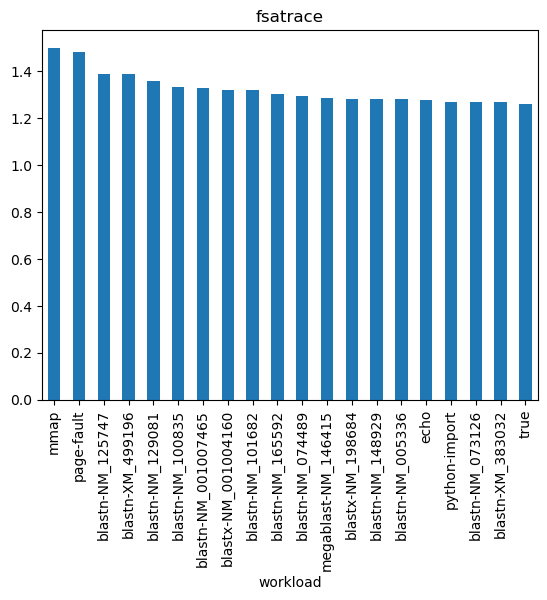

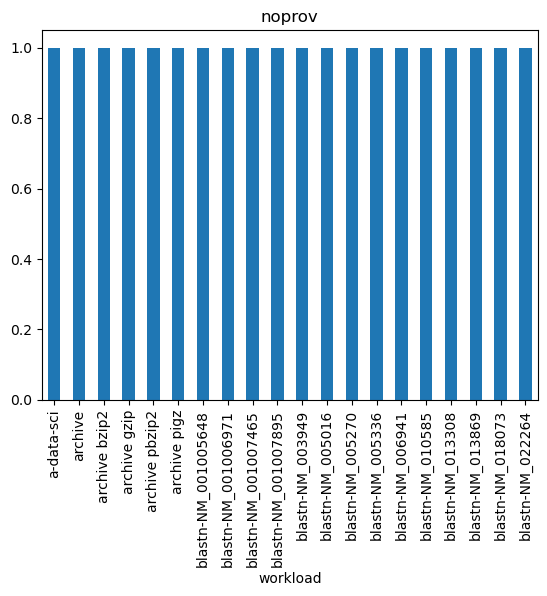

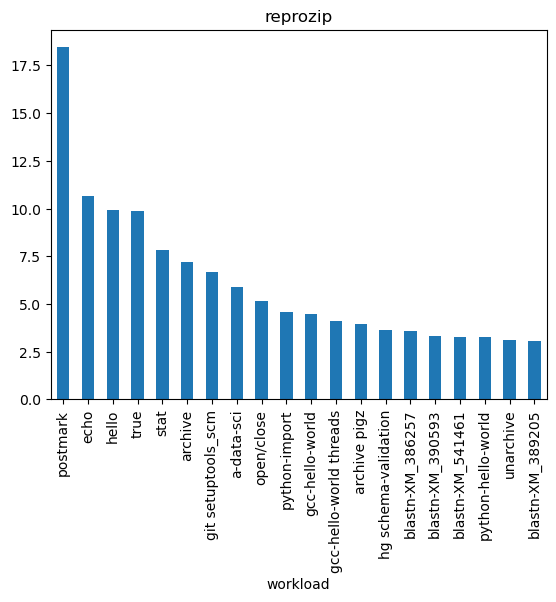

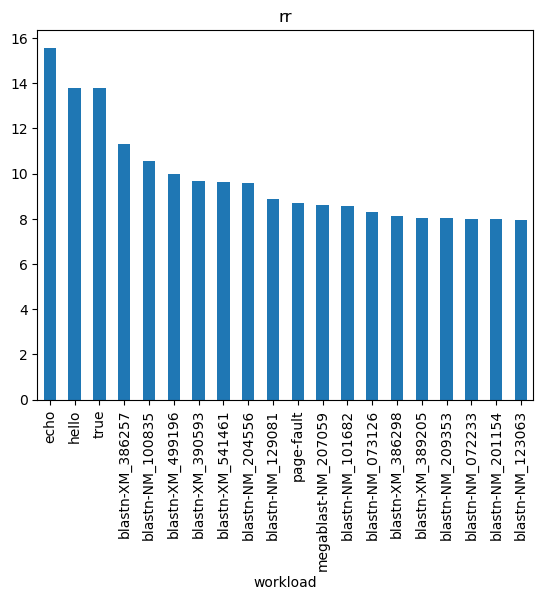

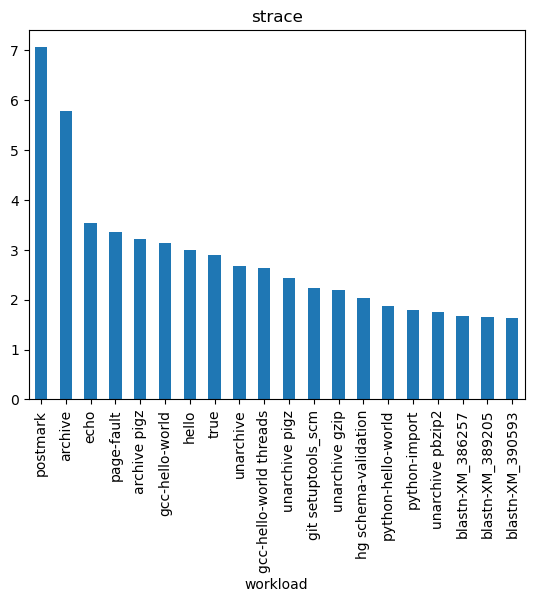

In [18]:
for collector in agged.index.levels[0]:
    fig = matplotlib.figure.Figure()
    ax = fig.add_subplot(1, 1, 1)
    ax = agged.loc[collector]["rel_slowdown"].nlargest(20).plot.bar(ax=ax)
    ax.set_title(collector)
    display(fig)

In [226]:
mre = lambda expected, actual: numpy.exp(numpy.mean(numpy.fabs(numpy.log(expected / actual)))) - 1
data = agged.reset_index().pivot(columns="workload", index="collector", values="walltime_mean").to_numpy()
data.shape

(5, 247)

In [224]:
import scipy.linalg
left_sing_vecs, sing_vals, right_sing_vecs = scipy.linalg.svd(data, full_matrices=False)
approxes = [
    numpy.dot(left_sing_vecs[:, :k], numpy.dot(numpy.diag(sing_vals[:k]), right_sing_vecs[:k, :]))
    for k in range(1, len(svd_df) + 1)
]
svd_df = pandas.DataFrame({
    "sing_vals": sing_vals / 600,
    "mre": numpy.array([mre(approx, data) for approx in approxes])
})

(5, 247)


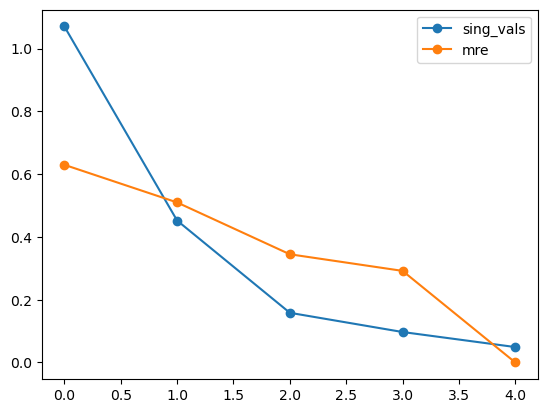

In [225]:
ax = svd_df.plot(marker="o")

# Using ID

In [ ]:
import scipy.linalg.interpolative_decomposition

idx, proj = scipy.linalg.interpolative.interp_decomp(data, k, rand=False)

In [134]:
mean_df = (
    df
    .groupby(["workload", "collector"], as_index=True, observed=True)
    .agg(**{
        qoi + "_abs_mean": pandas.NamedAgg(
            column=qoi,
            aggfunc="mean",
        )
        for qoi in rel_qois + abs_qois
    })
    .reset_index(["collector"])
    .assign(
        syscalls=lambda mean_df: mean_df[mean_df["collector"] == "strace"]["n_ops_abs_mean"],
        overhead=lambda mean_df: mean_df["walltime_abs_mean"] - mean_df[mean_df["collector"] == "noprov"]["walltime_abs_mean"],
    ).assign(
        overhead_per_syscall=lambda mean_df: mean_df["overhead"] / mean_df["syscalls"]
    )
)
mean_df

,collector,cputime_abs_mean,walltime_abs_mean,memory_abs_mean,storage_abs_mean,n_ops_abs_mean,syscalls,overhead,overhead_per_syscall
workload,,,,,,,,,
a-data-sci,fsatrace,43.13,23.13,4.76e+08,1.26e+06,9021.25,73122.0,0.62,8.50e-06
a-data-sci,noprov,38.78,22.51,5.06e+08,0.00e+00,0.00,73122.0,0.00,0.00e+00
a-data-sci,reprozip,562.80,264.54,5.02e+08,4.60e+01,6056.00,73122.0,242.03,3.31e-03
a-data-sci,rr,26.45,21.47,5.78e+08,3.81e+05,0.00,73122.0,-1.04,-1.42e-05
a-data-sci,strace,33.74,25.92,5.17e+08,9.90e+06,73122.00,73122.0,3.41,4.66e-05
...,...,...,...,...,...,...,...,...,...
write,fsatrace,11.59,11.59,1.43e+06,1.63e+02,3.00,91.5,-2.33,-2.54e-02
write,noprov,13.92,13.92,1.04e+06,0.00e+00,0.00,91.5,0.00,0.00e+00
write,reprozip,10.77,11.93,2.84e+07,4.60e+01,27.00,91.5,-1.99,-2.17e-02


In [7]:
def rel_err(actual, expected):
    return (actual - expected) / expected

In [24]:
(
    mean_df
    .assign(
        rel_slowdown=lambda df: 1 + rel_err(df["walltime_abs_mean"], df[df["collector"] == "noprov"]["walltime_abs_mean"])
    )
    .groupby("collector", observed=True)
    .agg(
        overhead_per_syscall_med=pandas.NamedAgg(
            column="rel_slowdown",
            aggfunc="median",
        ),
        overhead_per_syscall_5=pandas.NamedAgg(
            column="rel_slowdown",
            aggfunc=lambda data: numpy.percentile(data, 5),
        ),
        overhead_per_syscall_95=pandas.NamedAgg(
            column="rel_slowdown",
            aggfunc=lambda data: numpy.percentile(data, 95),
        ),
        overhead_per_syscall_mean=pandas.NamedAgg(
            column="rel_slowdown",
            aggfunc="mean",
        ),
        overhead_per_syscall_std=pandas.NamedAgg(
            column="rel_slowdown",
            aggfunc="std",
        ),
    )
)

,overhead_per_syscall_med,overhead_per_syscall_5,overhead_per_syscall_95,overhead_per_syscall_mean,overhead_per_syscall_std
collector,,,,,
fsatrace,1.017740,0.753175,1.398518,1.062505,0.372682
noprov,1.000000,1.000000,1.000000,1.000000,0.000000
reprozip,1.770930,0.976556,3.886296,2.021133,1.547359
rr,3.989394,1.013004,7.622853,3.960112,2.256392
strace,1.042185,0.829837,1.496698,1.142859,0.486389


In [20]:
collector_overhead = (
    mean_df
    .groupby("collector", observed=True)
    .agg(
        overhead_per_syscall_med=pandas.NamedAgg(
            column="overhead_per_syscall",
            aggfunc="median",
        ),
    )
)
collector_overhead

,overhead_per_syscall_med
collector,
fsatrace,0.000008
noprov,0.000000
reprozip,0.000603
rr,0.002968
strace,0.000034


In [25]:
dff = (
    mean_df
    .groupby(["collector", "workload"], observed=True)
    .agg(
        overhead_per_syscall_med=pandas.NamedAgg(
            column="overhead_per_syscall",
            aggfunc="median",
        ),
        walltime=pandas.NamedAgg(
            column="walltime_abs_mean",
            aggfunc="median",
        ),
    ).assign(
        overhead_per_syscall_rel_err=lambda df: rel_err(df["overhead_per_syscall_med"], collector_overhead["overhead_per_syscall_med"])
    )
)
dff[numpy.fabs(dff["overhead_per_syscall_rel_err"]) > 100]

overhead_per_syscall_med    walltime  \
collector workload                                                     
fsatrace  blastx-NG_000006b                     0.001813   42.469970   
          blastx-NG_007385b                    -0.004088   37.190238   
          blastx-NG_008953b                     0.002554   27.530922   
          bw_file_rd                            0.126204   17.056194   
          bw_pipe                               0.081153   31.841354   
          catch-signal                          0.117718   21.941761   
          getppid                              -0.028299   11.331852   
          install-signal                       -0.094920   11.320802   
          mmap                                  0.104764   15.375735   
          page-fault                            0.265461   41.659113   
          protection-fault                      0.021419   10.528909   
          read                                  0.020046   11.794081   
          select-file                          -0.011753   11.295324   
          tblastn-NP_308279                    -0.001311    4.594478   
          tblastn-NP_794869                    -0.002474   14.281914   
          tblastn-NP_977725                     0.001034    5.120354   
          tblastx-NM_001003472                 -0.000991   31.109855   
          tblastx-NM_011324                     0.001711   62.885561   
          tblastx-NM_060094                     0.004002   59.441194   
          tblastx-NM_116017                     0.003067   48.125127   
          tblastx-NM_133357                     0.001413   61.974178   
          tblastx-NM_202875                    -0.000981   17.528311   
          tblastx-XM_194279                    -0.002410   81.391455   
          write                                -0.025432   11.589412   
reprozip  bw_file_rd                            0.091011   13.888799   
          catch-signal                          0.127223   22.973088   
          install-signal                       -0.090069   11.745224   
          mmap                                  0.182779   22.397089   
          page-fault                            0.272098   42.412382   
rr        page-fault                            0.957894  120.250298   
strace    blastx-NG_007385b                    -0.004692   36.613480   
          bw_file_rd                            0.036669    8.998078   
          bw_pipe                              -0.008322   23.475383   
          bw_unix                               0.005249   23.894981   
          catch-signal                          0.126997   22.948529   
          getppid                              -0.024867   11.633855   
          install-signal                       -0.091123   11.653005   
          mmap                                  0.099337   14.887271   
          page-fault                            0.234635   38.160349   
          protection-fault                      0.022052   10.609619   
          read                                  0.019124   11.711583   
          select-file                          -0.010500   11.729098   
          tblastx-NM_060094                     0.003699   59.184452   
          tblastx-XM_194279                     0.006791   89.993649   
          write                                -0.024633   11.662554   

                                overhead_per_syscall_rel_err  
collector workload                                            
fsatrace  blastx-NG_000006b                       212.328419  
          blastx-NG_007385b                      -481.945069  
          blastx-NG_008953b                       299.485445  
          bw_file_rd                            14848.013153  
          bw_pipe                                9547.406020  
          catch-signal                          13849.514158  
          getppid                               -3330.606321  
          install-signal                       -11169.147680  
          mmap   